# NeuroData Design: Sprint 1, Week 8
Vivek Gopalakrishnan | October 23, 2018
___

This week, I analyzed the batch effects between HNU1 and HBN data. The edge weights of the graph have been PTR-ed.

**SUMMARY OF RESULTS:**
- As it stands, $k$-hop locality does not work well as a feature for discriminating sex
- There is a large batch effect

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

In [2]:
# Load the data
hnu = pd.read_csv('data/hnu1-weighted_klocality_with_age-sex.csv')
hnu.name = 'HNU1'

hbn = pd.read_csv('data/hbn-weighted_klocality_with_age-sex.csv')
hbn.name = 'HBN'

In [3]:
# Make a consistent color map
colors = ['b','r']
cmap = LinearSegmentedColormap.from_list('mylist', colors=colors)

## Step 1: Look at the data

These datasets were computed using the k-hop locality scan statistic (covered in week 6 and week 7):
- [Review of k-hop locality](http://nbviewer.jupyter.org/github/v715/NeuroData-fa18/blob/master/presentations/week6/analysis.ipynb#Analyze-the-graph-using-scan-statistics)
- [Script to generate HNU1 feature matrix](http://nbviewer.jupyter.org/github/v715/NeuroData-fa18/blob/master/presentations/week8/hnu1/hnu1_binary_khop.ipynb)

### Summary of the datasets:
**HBN:** 
- Number of samples: $n=91$
- 2:1 class balance 
- No clusters apparent in the PCA projections

**HNU1:** 
- Number of samples: $n=300$ (30 patients, 10 technical replicates)
- 1:1 class balance
- Both sexes cluster around $(0, -100)$ but the green class is more spread out

In [4]:
n_samples = lambda df: df.shape[0]
class_balance = lambda df: sum(df['sex'])/df.shape[0]

summary_dictionary = {}

for df in [hbn, hnu]:
    summary_dictionary[df.name] = [n_samples(df), class_balance(df)]
    
print(summary_dictionary)

{'HBN': [91, 0.32967032967032966], 'HNU1': [300, 0.5]}


In [5]:
def visualize(df):
    
    '''
    Use PCA to reduce the dimensionality of the dataframe.
    Visualize it in 2D and 3D.
    Plot histogram of different PCs, stratified by class.
    '''
    
    # Transform the data using PCA
    pca = PCA(n_components=5)
    
    if df.name == 'HBN':
        X = pca.fit_transform(df[df.columns[3:]])
    elif df.name == 'HNU1':
        X = pca.fit_transform(df[df.columns[4:]])
    else:
        print('Pass either the HBN or HNU datasets.')
        
    print('Explained variance ratio: ')
    print(pca.explained_variance_ratio_)
    
    
    ### Create the figure
    fig = plt.figure(figsize=plt.figaspect(1/3))
    fig.suptitle(df.name)
    
    # axis 1
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(X[:,0], X[:,1], c=df['sex'], cmap=cmap, alpha=0.5)
    ax.set_title('2D')
    
    # axis 2
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=df['sex'], cmap=cmap, alpha=0.5)
    ax.set_title('3D')
        
    # axis 3
    ax = fig.add_subplot(1, 3, 3)  
    i = 0 # Choose a PC to plot
    x = X[list(df[df['sex']==0].index), i]
    y = X[list(df[df['sex']==1].index), i]
    
    ax.hist([x, y], alpha=0.5, color=colors)
    ax.set_title('PC{}'.format(i+1))
    
    plt.show()

Explained variance ratio: 
[0.55566032 0.07120888 0.05977143 0.03608996 0.03101224]


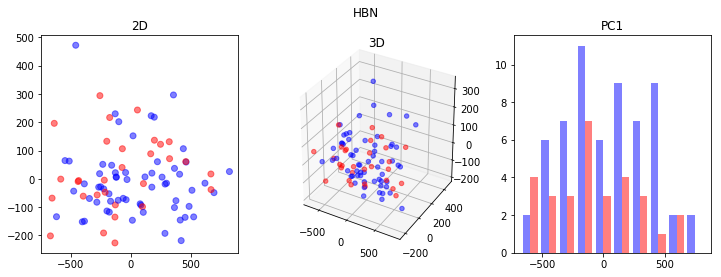

In [6]:
visualize(hbn)

Explained variance ratio: 
[0.74627762 0.05569545 0.0392137  0.01796401 0.01463907]


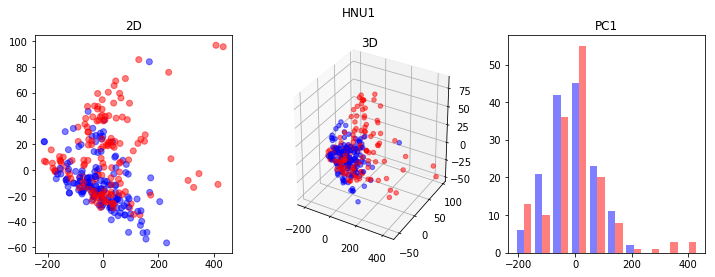

In [7]:
visualize(hnu)

### Visualization of the batch effect

1. Remove the phenotypic labels from the HBN and HNU1 datasets and combine them into a single data matrix
2. Reduce the dimensionality of the matrix using PCA
3. Add labels for which dataset the data came from
4. Plot in 2D with labels from part 3

In [8]:
# Make a copy of the HBN dataset
X1 = hbn[hbn.columns[3:]]
# Add a label column
X1.loc[:, 'dataset'] = [0] * X1.shape[0]

# Make a copy of the HNU1 dataset
X2 = hnu[hnu.columns[4:]]
# Add a label column
X2.loc[:, 'dataset'] = [1] * X2.shape[0]

# Combine the dataframes
df = X1.append(X2, ignore_index=True)

# Perform PCA on all columns except the label column
pca = PCA(n_components=5)
X = pca.fit_transform(df[df.columns[:-1]])

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


[]

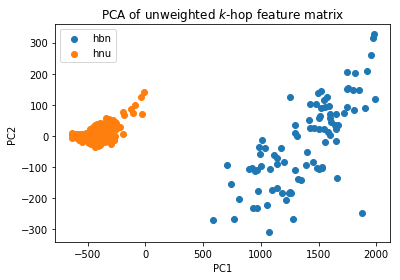

In [9]:
plt.scatter(X[:X1.shape[0],0], X[:X1.shape[0],1], label='hbn')
plt.scatter(X[-X2.shape[0]:,0], X[-X2.shape[0]:,1], label='hnu')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'PCA of unweighted $k$-hop feature matrix')

plt.legend()
plt.plot()

There is a clear separation between datasets. What a pronounced batch effect!

## Step 2: Test the batch effect

Perform the following training and testing combinations:
- Train: HNU1, Test: HBN
- Train: HNU1, Test: HNU1
- Train: HBN, Test: HNU1
- Train: HBN, Test: HBN

### Methodology of the experiment:
- Pick the training set
- Pick the testing set
- If train = test: validate accuracy with 5-fold CV
- Else: train and test normally

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [11]:
kf = KFold(n_splits=5)
clf = RandomForestClassifier(n_estimators=500)

In [12]:
def get_data_and_labels(df):
    
    pca = PCA(n_components=5)
    
    if df.name == 'HBN':
        df_data = df[df.columns[3:]]
        X = pca.fit_transform(df[df.columns[3:]])
    elif df.name == 'HNU1':
        df_data = df[df.columns[4:]]
        X = pca.fit_transform(df[df.columns[4:]])
    else:
        print('Pass either the HBN or HNU datasets.')
        
    labels = df['sex']
    return df_data, X, labels

In [13]:
def batch_same(df):
    
    # Get data and labels
    df_data, X, labels = get_data_and_labels(df)
    
    # Train and test using 5fold CV
    res = []

    for i in range(10):
        
        acc = []

        for train, test in kf.split(df):

            # Split into train/test sets
            # X_train, y_train, X_test, y_test = df_data.iloc[train], labels.iloc[train], df_data.iloc[test], labels.iloc[test]
            X_train, y_train, X_test, y_test = X[train], labels.iloc[train], X[test], labels.iloc[test]

            # Fit training data to model and predict test cases
            y_pred = clf.fit(X_train, y_train).predict(X_test)

            # Score the prediction
            acc.append(accuracy_score(y_test, y_pred))

        res.append(np.mean(acc))
        
    return res

In [14]:
def batch_different(df1, df2):
    
    X_train, X, y_train = get_data_and_labels(df1)
    X_test, X, y_test = get_data_and_labels(df2)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    return accuracy_score(y_test, y_pred)

In [15]:
combinations = [(hnu, hbn), (hnu, hnu), (hbn, hnu), (hbn, hbn)]

In [16]:
for combination in combinations:
    
    print(combination[0].name, combination[1].name)
    
    if combination[0].name==combination[1].name:
        print(np.mean(batch_same(combination[0])))
    else:
        i = []
        for _ in range(10):
            acc = batch_different(combination[0], combination[1])
            i += [max((1-acc), acc)]
        print(np.mean(i))

HNU1 HBN
0.6703296703296704
HNU1 HNU1
0.5643333333333334
HBN HNU1
0.5033333333333334
HBN HBN
0.6764327485380117
